# Gaussian posterior far from prior

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# For ABC
import pyabc
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scipy
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

We hypothesize that ABC methods struggle to generate samples when the prior (or proposal) mass is far from the posterior mass. 

We can test this in 1D by considering the following example:

$$p(\theta) = N(\theta ; 0, 1)$$

$$p(x|\theta) = N(x; 0 , 1)$$

where we observe $x_\text{obs} = x \in \{0,1,2,3,...\}$ ($x_\text{obs}$ is $x$ standard deviations above the mean of the prior). In this case, we have a posterior given analytically by

$$p(\theta|x_\text{obs}) = N\left(\theta; \frac{x}{2}, \frac{1}{2}\right)$$

We expect that, for large enough $x$ (think over $\approx 4\sigma$ away from prior mean), the ABC algorithms will struggle to sample from the true posterior, since its mass is far from the mass of the prior.

In [2]:
def prior_pdf(theta):
    return np.exp(-theta**2/2)/np.sqrt(2*np.pi)

def likelihood_pdf(x, theta):
    return np.exp(-(x-theta)**2/2)/np.sqrt(2*np.pi)

def evidence_pdf(x):
    return np.exp(-x**2/4) / (2*np.sqrt(np.pi))

def posterior_pdf(theta, x):
    return prior_pdf(theta) * likelihood_pdf(x, theta) / evidence_pdf(x)

In [13]:
# For plotting
x_range = np.linspace(-5,30,1000)
theta_range = np.linspace(-5,30,1000)

### Plot likelihood

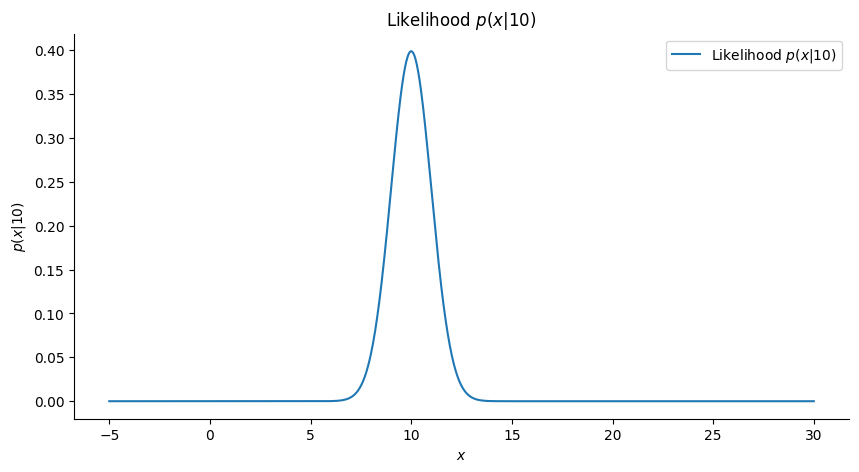

In [14]:
true_theta = 10
fig, ax = plt.subplots(figsize=(10,5))
label = fr"Likelihood $p(x|{true_theta})$"
ax.plot(x_range, likelihood_pdf(x_range, true_theta), label=label)
ax.set_xlabel(r"$x$")
ax.set_ylabel(fr"$p(x|{true_theta})$")
ax.set_title(fr"Likelihood $p(x|{true_theta})$")
plt.legend()

# Plot prior and posterior

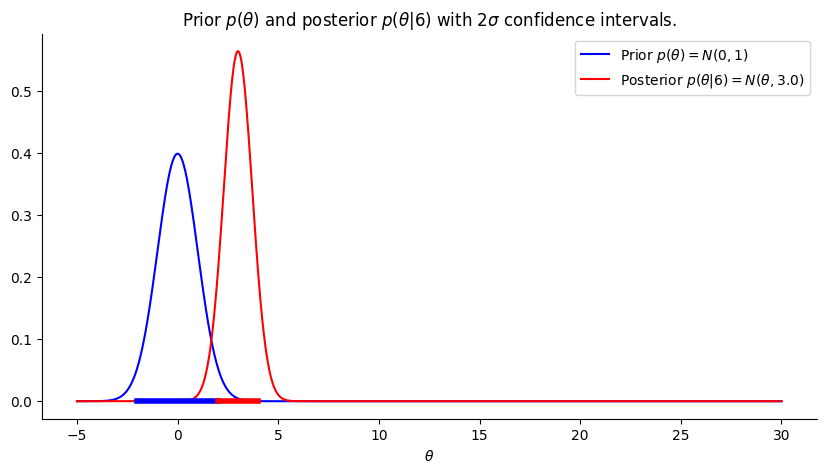

In [51]:
x_observed = 6
fig, ax = plt.subplots(figsize=(10,5))

# Plot prior
label_prior = r"Prior $p(\theta) = N(0,1)$"
ax.plot(theta_range, prior_pdf(theta_range), label=label_prior, color="blue")

# Plot posterior
label_posterior = fr"Posterior $p(\theta|{x_observed}) = N(\theta, {x_observed/2})$"
ax.plot(theta_range, posterior_pdf(theta_range, x_observed), label=label_posterior, color="red")

# Plot 2 sigma confidence interval of prior
ax.plot([-2,2], [0,0], color="blue", linewidth=4)

# Plot 2 sigma confidence interval of posterior
ax.plot([(x_observed/2 - 2 * 0.5), (x_observed/2 + 2 * 0.5)], [0,0], color="red", linewidth=4)

ax.set_xlabel(r"$\theta$")
ax.set_title(fr"Prior $p(\theta)$ and posterior $p(\theta|{x_observed})$ with $2\sigma$ confidence intervals.")
plt.legend()

### Rejection ABC

In [88]:
def model(theta):
    return np.random.normal(loc=theta, scale=1)

In [89]:
prior = scipy.stats.distributions.norm(0, 1)
proposal = prior # Take proposal to be the prior for simplicity

In [90]:
def distance(x, x0):
    return abs(x - x0)

Below, we implement the vanilla ABC Rejection Sampling (ABC-RS) algorithm for fixed acceptance threshold $\epsilon$. Note that if $\epsilon$ is too small, this algorithm will run indefinitely and not produce the required number of accepted samples.

In [114]:
def ABC_RS(model, prior, distance, x_observed, n_samples, epsilon, show_progress=False):
    """
    Perform ABC Rejection Sampling (ABC-RS) to draw approximate posterior samples.

    Parameters
    ----------
    model : callable
        Generative model that simulates data given a parameter value `theta`.
    prior : scipy.stats distribution or similar
        Prior distribution used to propose parameter samples. Must implement `.rvs()`.
    distance : callable
        Function that measures the discrepancy between simulated and observed data.
        Must accept `(x_simulated, x_observed)` and return a non-negative scalar.
    x_observed : float
        Observed value of x to which simulated data are compared.
    n_samples : int
        Number of accepted samples to draw from the approximate posterior.
    epsilon : float
        Acceptance threshold for the distance function.
    show_progress : bool, optional
        If True, prints sampling progress at regular intervals of 100,000
        samples. Default is False.

    Returns
    -------
    list
        A list of accepted parameter values approximating samples from the posterior
        distribution under the ABC rejection scheme.
    """
    accepted_samples = [] # Initialize list of accepted parameter samples.
    n_iter = 0 # Initialize total number of iterations.
    while len(accepted_samples) < n_samples:
        n_iter += 1
        # Print progress
        if n_iter % 100000 == 0 and show_progress:
            print(f"Accepted: {len(accepted_samples)} / {n_samples} after {n_iter} iterations. Acceptance rate = {round(100 * len(accepted_samples) / n_iter, 2)}%")
        theta_proposed = proposal.rvs().item() # Draw from prior
        x_simulated = model(theta_proposed) # Simulate data from likelihood given prior draw
        if distance(x_simulated, x_observed) <= epsilon:
            accepted_samples.append(theta_proposed) # Accept if distance is less than epsilon from true data.
    if show_progress:
        print(fr"FINAL: {n_samples} samples with epsilon = {epsilon} generated in {n_iter} iterations of ABC rejection sampling")
    return accepted_samples

In [ ]:
n_samples = 1000
epsilon = 1
ABC_RS_samples = ABC_RS(model, prior, distance, x_observed=x_observed, n_samples=n_samples, epsilon=epsilon, show_progress=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

# Plot prior
label_prior = r"Prior $p(\theta) = N(0,1)$"
ax.plot(theta_range, prior_pdf(theta_range), label=label_prior, color="blue")

# Plot posterior
label_posterior = fr"Posterior $p(\theta|{x_observed}) = N(\theta, {x_observed/2})$"
ax.plot(theta_range, posterior_pdf(theta_range, x_observed), label=label_posterior, color="red")

# Plot 2 sigma confidence interval of prior
ax.plot([-2,2], [0,0], color="blue", linewidth=4)

# Plot 2 sigma confidence interval of posterior
ax.plot([(x_observed/2 - 2 * 0.5), (x_observed/2 + 2 * 0.5)], [0,0], color="red", linewidth=4)

# Plot ABC-RS samples
ax.hist(ABC_RS_samples, density=True, bins=60, label=f"Histogram of {n_samples} ABC-RS samples")
ax.set_title(fr"ABC Rejection Sampling with $\epsilon$ = {epsilon}")

ax.set_xlabel(r"$\theta$")
ax.set_title(fr"Prior $p(\theta)$ and posterior $p(\theta|{x_observed})$ with $2\sigma$ confidence intervals.")
plt.legend()

Below, we define an `epsilon_tuner`, which adaptively updates the threshold $\epsilon$ to target a `target_acceptance_rate`. This is a sub-function of the `ABC_RS_adaptive` function (defined later).

In [115]:
def epsilon_tuner(initial_epsilon,
                  target_accpetance_rate, # Target acceptance rate in percentage
                  model, prior, distance, x_observed, 
                  n_iterations_per_calibration=100000, # Number of ABC-RS iterations per calibration step
                  n_calibration=10, # Number of calibration steps
                  learning_rate=10): # Learning rate for Robbins-Monro style update to epsilon
    """
    Calibrate the epsilon threshold for Rejection ABC
    using a Robbins–Monro style stochastic approximation scheme.

    This function iteratively tunes the ABC acceptance threshold `epsilon` so that the
    acceptance rate of proposed samples approximates a user-defined target acceptance
    rate. At each calibration step, rejection ABC is performed for a fixed number of
    iterations, and epsilon is updated according to the observed acceptance rate.

    Parameters
    ----------
    initial_epsilon : float
        Initial value of the epsilon threshold for ABC acceptance.
    target_accpetance_rate : float
        Desired acceptance rate (in percentage) to be achieved by calibration.
    model : callable
        Data-generating model. Must accept a parameter sample `theta` and return
        a simulated dataset.
    prior : scipy.stats distribution or similar
        Prior distribution from which parameter proposals are drawn. Must implement
        a `.rvs()` method.
    distance : callable
        Distance function used to compare the simulated dataset and the observed
        data. Must accept two inputs and return a non-negative scalar.
    x_observed : float
        Observed value of x to which simulated data are compared.
    n_iterations_per_calibration : int, optional
        Number of ABC iterations performed at each calibration step. Default is 100,000.
    n_calibration : int, optional
        Number of calibration steps to perform. Default is 10.
    learning_rate : float, optional
        Learning rate controlling how aggressively epsilon is updated at each step.
        Larger values lead to faster but potentially unstable updates. Default is 10.

    Returns
    -------
    epsilons : list of float
        Sequence of epsilon values obtained across calibration steps (excluding the
        initial epsilon). Length equals `n_calibration`.
    acceptance_rates : list of float
        Observed acceptance rates (in percentage) at each calibration step. Length 
        equals `n_calibration`.
    """
    
    target_accpetance_rate = target_accpetance_rate/100 # Convert from percentage to decimal
    epsilons = [initial_epsilon] # Initialize list of epsilons
    acceptance_rates = []
    
    for _ in range(n_calibration):
        epsilon = epsilons[-1]
        n_accepted_samples = 0
        for __ in range(n_iterations_per_calibration):
            theta_proposed = proposal.rvs().item()
            x_simulated = model(theta_proposed)
            if distance(x_simulated, x_observed) <= epsilon:
                n_accepted_samples += 1
        acceptance_rate = n_accepted_samples / n_iterations_per_calibration
        acceptance_rates.append(acceptance_rate*100)
        epsilons.append((epsilon * np.exp(- learning_rate * (acceptance_rate - target_accpetance_rate))).item())
    
    return epsilons[1::], acceptance_rates


Below we illustrate the $\epsilon$-calibration algorithm for an "easy" posterior where we condition on the observation $x=2$, which results in a posterior whose mass is not too far from the prior mass. 

$$p(\theta|2) = N\left(\theta; 1, \frac{1}{2}\right)$$

We set $\epsilon_\text{initial} = 1$ (a rather large value), and we expect the algorithm to reduce epsilon until a target acceptance rate of $2\%$ is reached:  

In [138]:
initial_epsilon = 1
target_accpetance_rate = 2
n_iterations_per_calibration = 100000
n_calibration = 10
learning_rate = 10
x_observed = 2

epsilons, acceptance_rates = epsilon_tuner(initial_epsilon=initial_epsilon,
                  target_accpetance_rate=target_accpetance_rate, 
                  model=model, prior=prior, distance=distance, x_observed=x_observed, 
                  n_iterations_per_calibration=n_iterations_per_calibration,
                  n_calibration=n_calibration,
                  learning_rate=learning_rate)

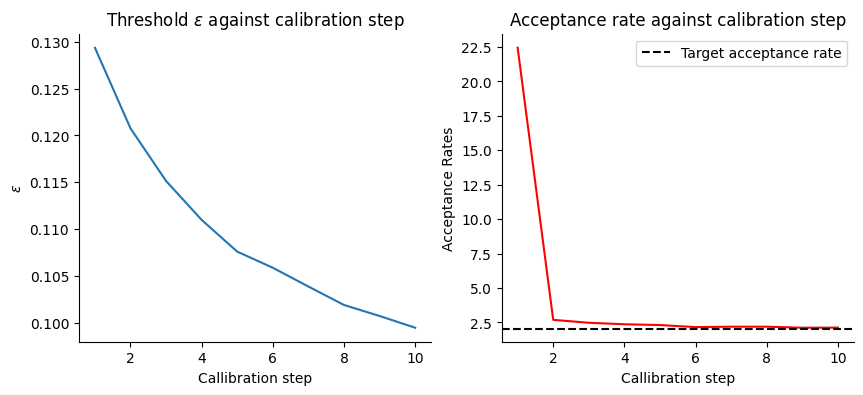

In [139]:
fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

ax[0].plot(range(1,len(epsilons)+1), epsilons)
ax[0].set_xlabel('Callibration step')
ax[0].set_ylabel(r'$\epsilon$')

ax[1].plot(range(1,len(epsilons)+1), acceptance_rates, color='red')
ax[1].set_xlabel('Callibration step')
ax[1].set_ylabel('Acceptance Rates')
ax[1].axhline(target_accpetance_rate, label="Target acceptance rate", color="black", linestyle='--')

# Add titles
ax[0].set_title('Threshold $\epsilon$ against calibration step')
ax[1].set_title('Acceptance rate against calibration step')

plt.legend()
plt.show()


Below we illustrate the $\epsilon$-calibration algorithm for a "hard" posterior where we condition on the observation $x=8$, which results in a posterior whose mass is far from the prior mass. 

$$p(\theta|8) = N\left(\theta; 4, \frac{1}{2}\right)$$

We set $\epsilon_\text{initial} = 1$ (a rather large value), but due to the far prior, we expect the algorithm to increase epsilon until a target acceptance rate of $2\%$ is reached:

In [140]:
initial_epsilon = 1
target_accpetance_rate = 2
n_iterations_per_calibration = 100000
n_calibration = 20
learning_rate = 10
x_observed = 8

epsilons, acceptance_rates = epsilon_tuner(initial_epsilon=initial_epsilon,
                  target_accpetance_rate=target_accpetance_rate, 
                  model=model, prior=prior, distance=distance, x_observed=x_observed, 
                  n_iterations_per_calibration=n_iterations_per_calibration,
                  n_calibration=n_calibration,
                  learning_rate=learning_rate)

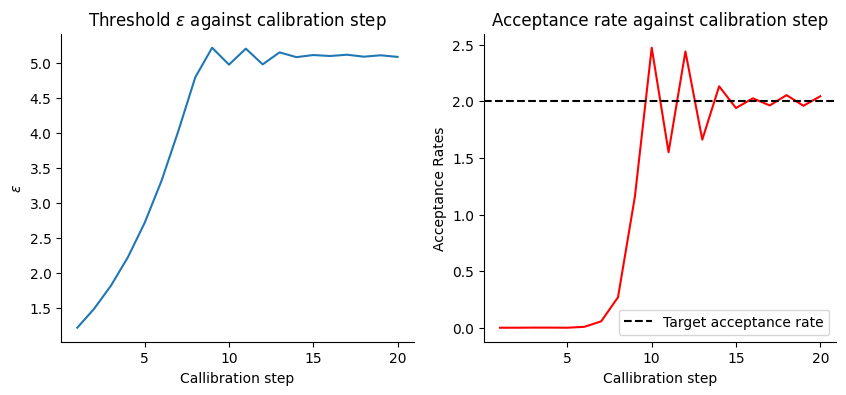

In [141]:
fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

ax[0].plot(range(1,len(epsilons)+1), epsilons)
ax[0].set_xlabel('Callibration step')
ax[0].set_ylabel(r'$\epsilon$')

ax[1].plot(range(1,len(epsilons)+1), acceptance_rates, color='red')
ax[1].set_xlabel('Callibration step')
ax[1].set_ylabel('Acceptance Rates')
ax[1].axhline(target_accpetance_rate, label="Target acceptance rate", color="black", linestyle='--')

# Add titles
ax[0].set_title('Threshold $\epsilon$ against calibration step')
ax[1].set_title('Acceptance rate against calibration step')

plt.legend()
plt.show()


### Varying $x_\text{obs}$

Below, we compute the ABC-RS posterior approximation for various $x_\text{obs}$. 

In [84]:
x_observed_values = [0,2,4,6]
posterior_samples = dict()
n_samples = 1000
epsilon = 1

1000 samples with epsilon = 1 generated in 1858 iterations of ABC rejection sampling


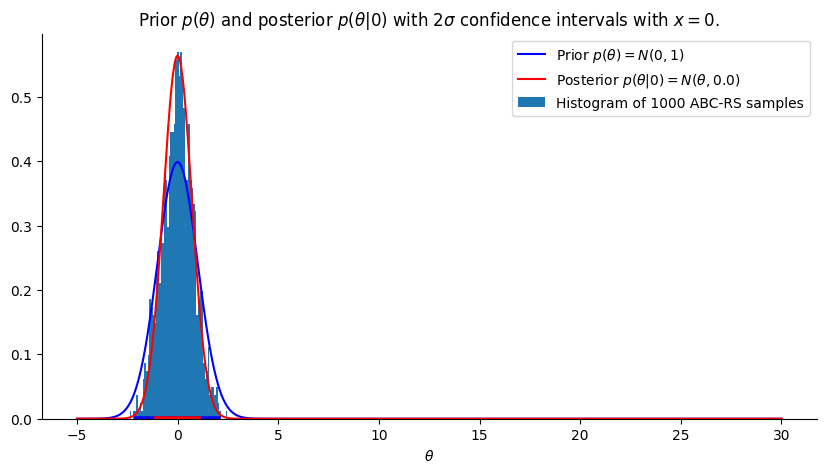

1000 samples with epsilon = 1 generated in 4482 iterations of ABC rejection sampling


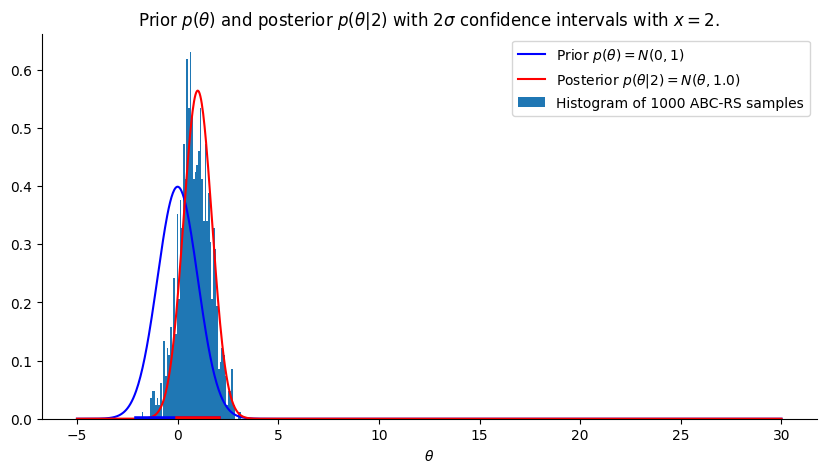

1000 samples with epsilon = 1 generated in 63648 iterations of ABC rejection sampling


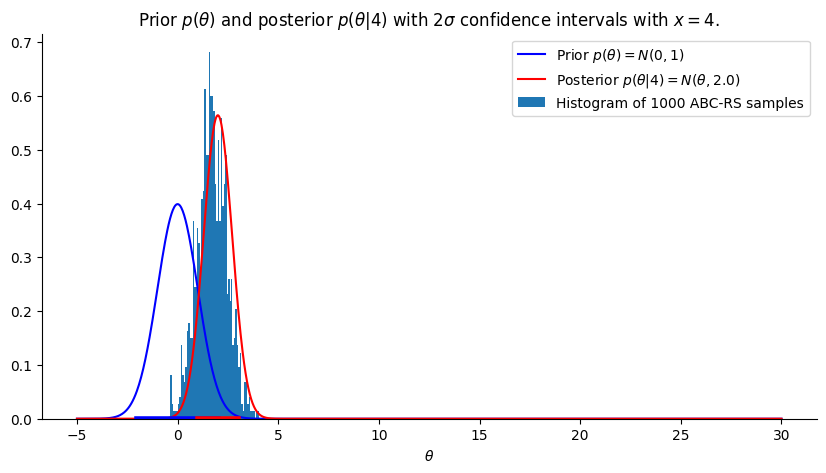

Accepted: 16 / 1000 after 100000 iterations. Acceptance rate = 0.02%
Accepted: 38 / 1000 after 200000 iterations. Acceptance rate = 0.02%
Accepted: 54 / 1000 after 300000 iterations. Acceptance rate = 0.02%
Accepted: 72 / 1000 after 400000 iterations. Acceptance rate = 0.02%
Accepted: 94 / 1000 after 500000 iterations. Acceptance rate = 0.02%
Accepted: 111 / 1000 after 600000 iterations. Acceptance rate = 0.02%
Accepted: 132 / 1000 after 700000 iterations. Acceptance rate = 0.02%
Accepted: 155 / 1000 after 800000 iterations. Acceptance rate = 0.02%
Accepted: 171 / 1000 after 900000 iterations. Acceptance rate = 0.02%
Accepted: 185 / 1000 after 1000000 iterations. Acceptance rate = 0.02%
Accepted: 204 / 1000 after 1100000 iterations. Acceptance rate = 0.02%
Accepted: 216 / 1000 after 1200000 iterations. Acceptance rate = 0.02%
Accepted: 227 / 1000 after 1300000 iterations. Acceptance rate = 0.02%
Accepted: 249 / 1000 after 1400000 iterations. Acceptance rate = 0.02%
Accepted: 267 / 1000

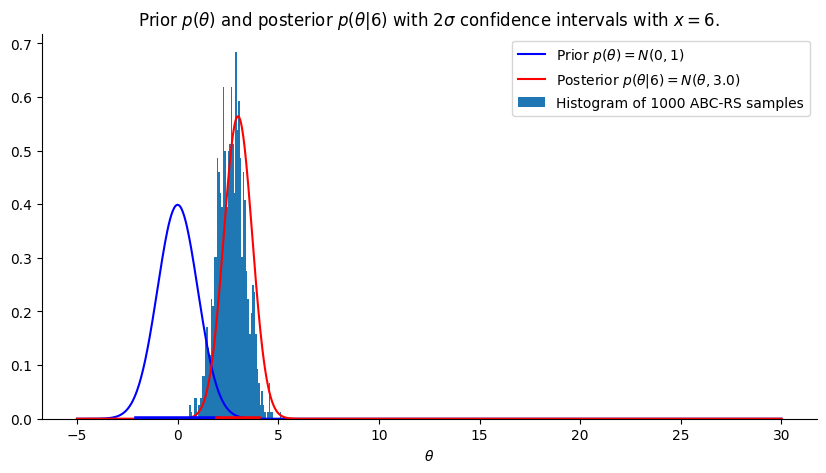

In [85]:
for x_observed in x_observed_values:
    fig, ax = plt.subplots(figsize=(10,5))

    posterior_samples_ = ABC_RS(model, prior, distance, x_observed=x_observed, n_samples=n_samples, epsilon=epsilon)
    posterior_samples[f"x = {x_observed}"] = posterior_samples_

    # Plot prior
    label_prior = r"Prior $p(\theta) = N(0,1)$"
    ax.plot(theta_range, prior_pdf(theta_range), label=label_prior, color="blue")

    # Plot posterior
    label_posterior = fr"Posterior $p(\theta|{x_observed}) = N(\theta, {x_observed/2})$"
    ax.plot(theta_range, posterior_pdf(theta_range, x_observed), label=label_posterior, color="red")

    # Plot 2 sigma confidence interval of prior
    ax.plot([-2,2], [0,0], color="blue", linewidth=4)

    # Plot 2 sigma confidence interval of posterior
    ax.plot([(x_observed/2 - 2 * 0.5), (x_observed/2 + 2 * 0.5)], [0,0], color="red", linewidth=4)

    # Plot ABC-RS samples
    ax.hist(posterior_samples_, density=True, bins=60, label=f"Histogram of {n_samples} ABC-RS samples")
    ax.set_title(fr"ABC Rejection Sampling with $\epsilon$ = {epsilon}")

    ax.set_xlabel(r"$\theta$")
    ax.set_title(fr"Prior $p(\theta)$ and posterior $p(\theta|{x_observed})$ with $2\sigma$ confidence intervals with $x = {x_observed}$.")
    plt.legend()
    plt.show()
    posterior_samples["x = {}"] = 2

{'i': 2}

# SBC

In [ ]:
def abc_rs_sbi(model, prior, distance, n_samples=100, num_sbi_runs=100, epsilon=0.1):
    ranks = []
    for i in range(num_sbi_runs):
        prior_sample = prior.rvs() # Sample from prior.
        x_simulated = model(prior_sample) # Simulate a datapoint from the model given the prior sample.
        posterior_samples = np.array(ABC_RS(model, prior, distance, x_simulated, n_samples, epsilon)) # Numpy array of (n_samples, ) samples.
        rank = np.sum(prior_sample * np.ones_like(posterior_samples) > posterior_samples)/n_samples # Rank statistic
        ranks.append(float(rank))
    plt.hist(ranks, label=f"SBC rank histogram with {num_sbi_runs} SBI runs and {n_samples} samples per run.")
    plt.xlim(0, 1)
    plt.xlabel("Rank")
    plt.legend()
    plt.show()
    return ranks